In [1]:
import pyimzml.ImzMLParser
from scipy.ndimage import gaussian_filter1d,white_tophat
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

def cluster_msi(filename,output_directory,sample_name,sigma,structuring_element_size,pca_components,
           tsne_components,tsne_verbose,tsne_perplexity,tsne_interations,k_means_cluster_number):
    parser = pyimzml.ImzMLParser.ImzMLParser(filename) #load imzML file
    # Initialize lists to store data
    coordinates = []
    mz_values = []
    intensities = []

    # Iterate through the spectra and extract data
    for idx, (x, y, z) in enumerate(parser.coordinates):
        mzs, intens = parser.getspectrum(idx)

        # Apply Gaussian smoothing
        smoothed_intens = gaussian_filter1d(intens, sigma=sigma)

        # Apply top-hat baseline subtraction
        baseline_corrected_intens = white_tophat(smoothed_intens, size=structuring_element_size)

        coordinates.append((x, y))
        mz_values.append(mzs)
        intensities.append(baseline_corrected_intens)

    # Create a DataFrame
    df = pd.DataFrame({
        'x': [coord[0] for coord in coordinates],
        'y': [coord[1] for coord in coordinates],
        'mz_values': mz_values,
        'intensities': intensities
    })

    # Ensure that all m/z values are aligned and intensities are flattened
    all_mz_values = np.unique(np.concatenate(df['mz_values'].values))
    intensity_matrix = np.zeros((len(df), len(all_mz_values)))

    for i, (mzs, intens) in enumerate(zip(df['mz_values'], df['intensities'])):
        intensity_matrix[i, np.searchsorted(all_mz_values, mzs)] = intens

    # Convert the intensity matrix to a DataFrame
    intensity_df = pd.DataFrame(intensity_matrix, columns=all_mz_values)

    # Combine coordinates with the intensity data
    df_final = pd.concat([df[['x', 'y']], intensity_df], axis=1)

    # Perform PCA
    pca = PCA(n_components=pca_components)
    pca_result = pca.fit_transform(intensity_matrix)

    # Perform t-SNE
    tsne = TSNE(n_components=tsne_components, verbose=tsne_verbose, perplexity=tsne_perplexity, n_iter=tsne_interations)
    tsne_result = tsne.fit_transform(pca_result)

    # Add t-SNE results back to DataFrame
    df['tsne-one'] = tsne_result[:, 0]
    df['tsne-two'] = tsne_result[:, 1]

    # Cluster using K-means
    kmeans = KMeans(n_clusters=k_means_cluster_number)
    df['cluster'] = kmeans.fit_predict(pca_result)

    # Visualize the t-SNE result
    #plt.figure(figsize=(16, 10))
    #sns.scatterplot(
    #    x="tsne-one", y="tsne-two",
    #    hue="cluster",
    #    palette=sns.color_palette("tab10"),
    #    data=df,
    #    legend="full",
    #    alpha=0.6
    #)
    #plt.title('t-SNE of Mass Spectrometry Image with K-means Clustering')
    #plt.show()

    # Define a fixed color map
    cluster_colors = {
        0: '#1f77b4',  # Blue
        1: '#ff7f0e',  # Orange
        2: '#2ca02c',  # Green
        3: '#d62728',  # Red
        4: '#9467bd',  # Purple
        5: '#EC2E8C',  # Pink
        6: '#f032e6',  # Yellow
        7: '#9CE060',  # Light green
    }

    # Create a colormap for the clusters
    cmap = plt.cm.colors.ListedColormap([cluster_colors[i] for i in range(k_means_cluster_number)])

    # Create the full cluster image
    width, height = max(df['x']), max(df['y'])
    cluster_image_full = np.zeros((width, height))

    for idx, row in df.iterrows():
        x, y = int(row['x']), int(row['y'])
        cluster_image_full[x-1, y-1] = row['cluster']

    # Display the full cluster image
    #plt.figure(figsize=(10, 10))
    #plt.imshow(cluster_image_full, cmap=cmap, interpolation='nearest')
    #plt.title('Cluster Image of Tissue Spectra')
    #plt.colorbar()
    #plt.show()

    #fig_outpath = output_directory + '\\' + sample_name + '_tSNE_cluster.png'
    #plt.savefig(fig_outpath)

    # Create custom legend handles for both images
    unique_clusters_full = np.unique(df['cluster'])
    legend_handles_full = [mpatches.Patch(color=cluster_colors[i], label=f'Cluster {i}') for i in unique_clusters_full]
    plt.figure(figsize=(10, 10))
    im_full = plt.imshow(cluster_image_full, cmap=cmap, interpolation='nearest')
    plt.title('Full Clustered Mass Spectrometry Image')
    plt.axis('off')
    plt.legend(handles=legend_handles_full, loc='upper right')

    fig_outpath = output_directory + '\\' + sample_name + '_MSI_tSNE_cluster_overlay.png'
    plt.savefig(fig_outpath,bbox_inches='tight')

    fig_outpath = output_directory + '\\' + sample_name + '_MSI_tSNE_cluster_overlay.png'
    plt.savefig(fig_outpath,bbox_inches='tight')
    
    return df,width, height,cluster_colors,cluster_image_full,cmap,legend_handles_full


C:\Users\lawashburn\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def cluster_removal(df,width,height,cluster_colors,cluster_image_full,cmap,legend_handles_full,clusters_to_remove,output_directory,sample_name):
    # Filter out the rows with clusters to remove
    filtered_df = df[~df['cluster'].isin(clusters_to_remove)]

    # Create the cluster image without specific clusters
    cluster_image_filtered = np.zeros((width, height)) - 1  # Initialize with -1 to handle missing data

    for idx, row in filtered_df.iterrows():
        x, y = int(row['x']), int(row['y'])
        cluster_image_filtered[x-1, y-1] = row['cluster']
    unique_clusters_filtered = np.unique(filtered_df['cluster'])
    legend_handles_filtered = [mpatches.Patch(color=cluster_colors[i], label=f'Cluster {i}') for i in unique_clusters_filtered]
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Full cluster image
    im_full = axes[0].imshow(cluster_image_full, cmap=cmap, interpolation='nearest')
    axes[0].set_title('Full Clustered Mass Spectrometry Image')
    axes[0].axis('off')
    axes[0].legend(handles=legend_handles_full, loc='upper right')

    # Filtered cluster image
    cmap_filtered = plt.cm.colors.ListedColormap([cluster_colors[i] for i in unique_clusters_filtered])
    im_filtered = axes[1].imshow(cluster_image_filtered, cmap=cmap_filtered, interpolation='nearest')
    axes[1].set_title('Clustered Mass Spectrometry Image without Specific Clusters')
    axes[1].axis('off')
    axes[1].legend(handles=legend_handles_filtered, loc='upper right')

    fig_outpath = output_directory + '\\' + sample_name + '_MSI_tSNE_cluster_overlay_w_clusters_remove.png'
    plt.savefig(fig_outpath,bbox_inches='tight')
    
    return filtered_df

In [3]:
def make_composite_image(df,threshold,output_directory,sample_name):
    def process_imzml(file_path):
        parser = ImzMLParser(file_path)
        data = []
        for idx, (x, y, z) in enumerate(parser.coordinates):
            mzs, intens = parser.getspectrum(idx)
            data.append((x, y, mzs, intens))

        df = pd.DataFrame(data, columns=['x', 'y', 'mz_values', 'intensities'])
        return df

    # Function to filter intensities above a given threshold
    def filter_intensities_above_threshold(mz_values, intensities, threshold):
        filtered_intensities = []
        for intens in intensities:
            mask = intens > threshold
            filtered_intensities.append(np.sum(intens[mask]))
        return np.array(filtered_intensities)

    # Function to create the composite image for intensities above a threshold
    def create_composite_image_for_intensity_threshold(df, threshold):
        width, height = max(df['x']), max(df['y'])
        composite_image = np.zeros((width, height))

        mz_values = np.array(df['mz_values'].tolist())
        intensities = np.array(df['intensities'].tolist())
        filtered_intensities = filter_intensities_above_threshold(mz_values, intensities, threshold)

        for (x, y), intens in zip(df[['x', 'y']].values, filtered_intensities):
            composite_image[x-1, y-1] += intens

        return composite_image

    # Create the composite image for intensities above the threshold
    composite_image = create_composite_image_for_intensity_threshold(df, threshold)

    # Plot the composite image with raw, unnormalized values using matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(composite_image, cmap='gray')
    plt.colorbar()
    title = 'Composite Image for Intensities Above Threshold='+str(threshold)
    plt.title(title)

    fig_outpath = output_directory + '\\' + sample_name + '_MSI_composite_image_all_mz.png'
    plt.savefig(fig_outpath,bbox_inches='tight')

    return composite_image

In [13]:
def composite_wo_selected_clusters(df,clusters_to_remove,composite_image,output_directory,sample_name):
    coordinates_to_remove = df[df['cluster'].isin(clusters_to_remove)][['x', 'y']].values
    list_coord = coordinates_to_remove.tolist()
    
    filtered_image = composite_image.copy()

    # Set the specified coordinates to zero
    for coord in list_coord:
        y, x = coord
        if x < filtered_image.shape[1] and y < filtered_image.shape[0]:
            filtered_image[y, x] = 0  # Note the swapped indices

    plt.imshow(filtered_image, cmap='viridis')
    fig_outpath = output_directory + '\\' + sample_name + '_MSI_filtered_image_w_clusters_removed.png'
    plt.savefig(fig_outpath,bbox_inches='tight')
    
    return filtered_image

In [19]:
def remove_residual_noise(filtered_image,median_filter_size,output_directory,sample_name):
    from skimage import filters
    from scipy.ndimage import median_filter, binary_erosion
    # Create a binary mask of the tissue region
    tissue_image = filtered_image.copy()

    threshold = filters.threshold_otsu(tissue_image)
    tissue_mask = tissue_image > threshold

    # Erode the mask to create a mask for the edges
    edge_mask = tissue_mask & ~binary_erosion(tissue_mask, iterations=5)

    # Apply the median filter to the entire image
    filtered_image = median_filter(tissue_image, size=median_filter_size)

    # Combine the filtered edges with the original image
    final_image = np.where(edge_mask, filtered_image, tissue_image)

    # Plot the original, mask, and final images
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(tissue_image, cmap='viridis')
    plt.title('Original Image')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(edge_mask, cmap='gray')
    plt.title('Edge Mask')
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(final_image, cmap='viridis')
    plt.title('Final Image (Filtered Edges)')
    plt.colorbar()

    fig_outpath = output_directory + '\\' + sample_name + '_MSI_median_filtered_image.png'
    plt.savefig(fig_outpath,bbox_inches='tight')
    
    return final_image

C:\Users\lawashburn\Anaconda3\lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 14990 samples in 0.009s...
[t-SNE] Computed neighbors for 14990 samples in 0.558s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14990
[t-SNE] Computed conditional probabilities for sample 2000 / 14990
[t-SNE] Computed conditional probabilities for sample 3000 / 14990
[t-SNE] Computed conditional probabilities for sample 4000 / 14990
[t-SNE] Computed conditional probabilities for sample 5000 / 14990
[t-SNE] Computed conditional probabilities for sample 6000 / 14990
[t-SNE] Computed conditional probabilities for sample 7000 / 14990
[t-SNE] Computed conditional probabilities for sample 8000 / 14990
[t-SNE] Computed conditional probabilities for sample 9000 / 14990
[t-SNE] Computed conditional probabilities for sample 10000 / 14990
[t-SNE] Computed conditional probabilities for sample 11000 / 14990
[t-SNE] Computed conditional probabilities for sample 12000 / 14990
[t-SNE] Computed conditional probabilities for sam

C:\Users\lawashburn\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


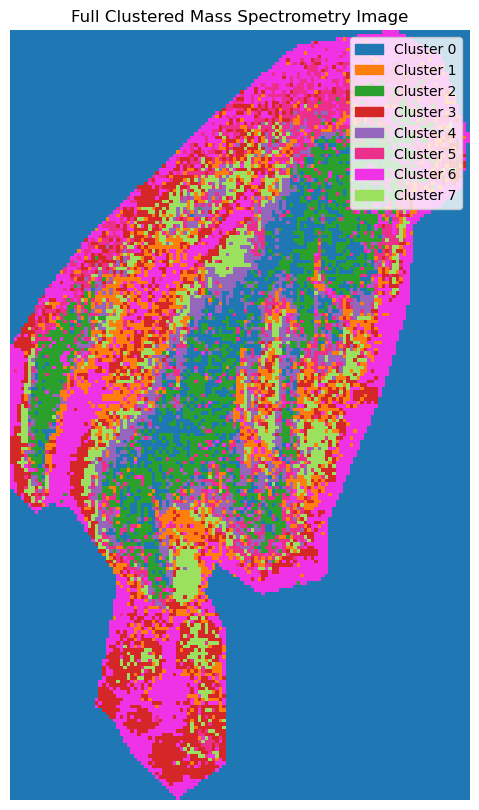

In [9]:
filename = r"D:\Manuscripts\2024_MSIight\480_Rapiflex_HE_files\MSIght\MALDI Data\r0012_tissue-total ion count.imzML"
output_directory = r"D:\Manuscripts\2024_MSIight\MSIght_results\final_code_test"
sample_name = 'R0012_norm_centroid'

###Advanced parameters###
sigma = 2  # Gaussian smoothing parameter
structuring_element_size = 10  # Top-hat baseline subtraction size
pca_components = 50 #50
tsne_components = 2
tsne_verbose = 1
tsne_perplexity = 5
tsne_interations = 300 #300
k_means_cluster_number = 8 #8

unfiltered_cluster_results,width,height,cluster_colors,cluster_image_full,cmap,legend_handles_full = cluster_msi(filename,output_directory,sample_name,sigma,structuring_element_size,pca_components,
                               tsne_components,tsne_verbose,tsne_perplexity,tsne_interations,k_means_cluster_number)

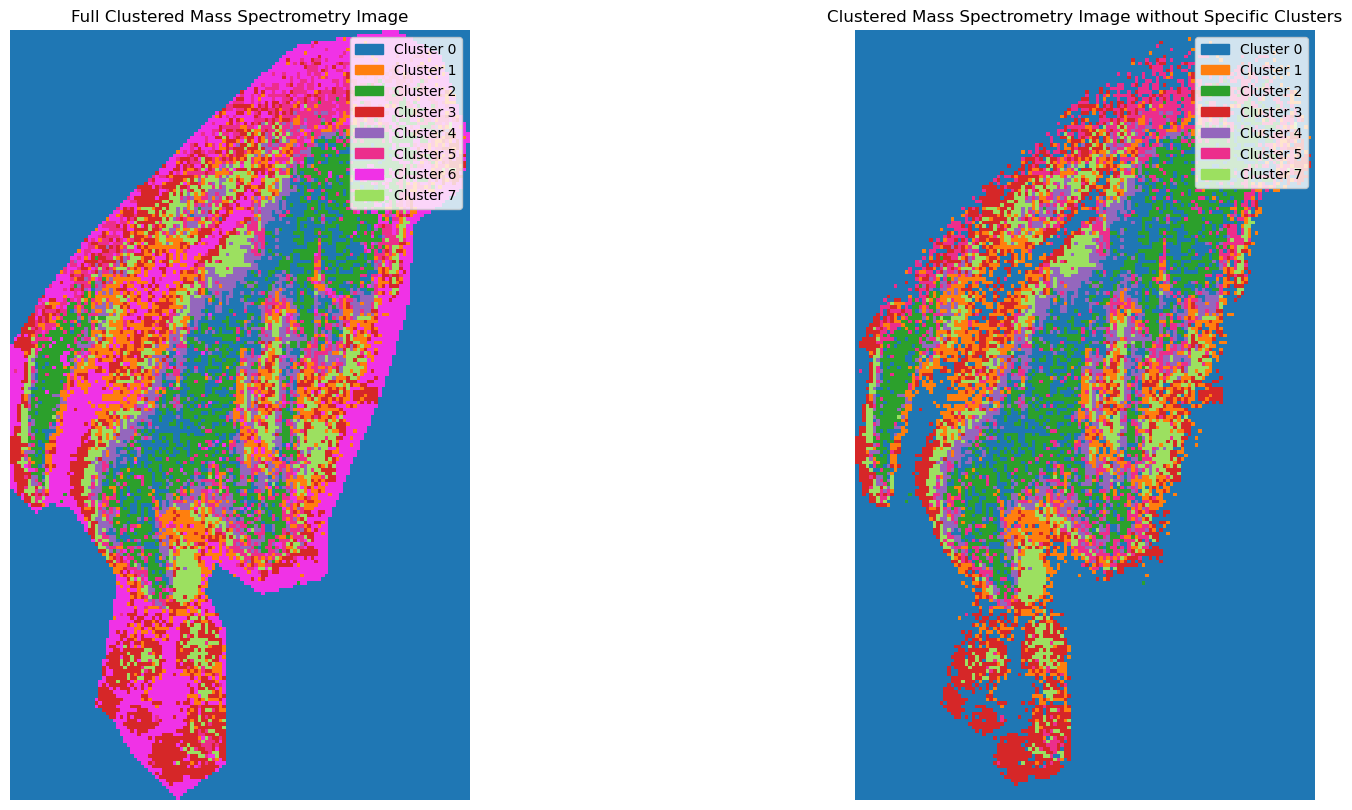

In [10]:
clusters_to_remove = [6]
filtered_cluster_results = cluster_removal(unfiltered_cluster_results,width,height,cluster_colors,cluster_image_full,
                                           cmap,legend_handles_full,clusters_to_remove,output_directory,sample_name)

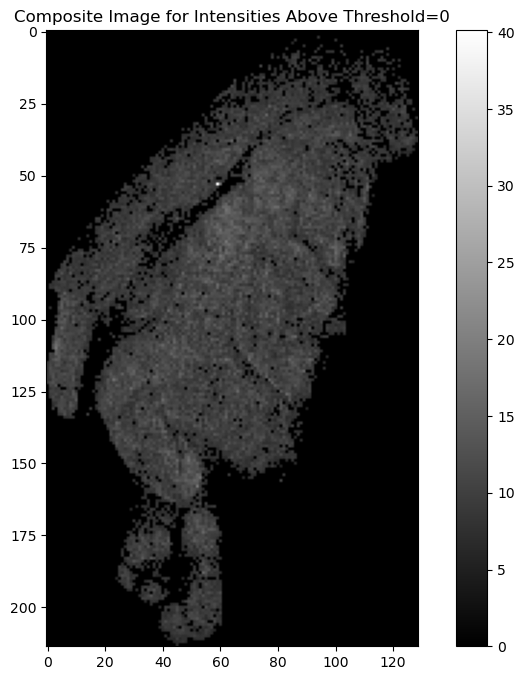

In [11]:
threshold = 0
full_composite_image = make_composite_image(filtered_cluster_results,threshold,output_directory,sample_name)

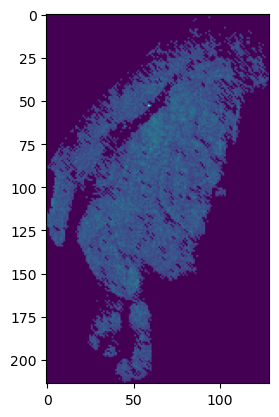

In [15]:
segmented_image = composite_wo_selected_clusters(unfiltered_cluster_results,clusters_to_remove,full_composite_image,output_directory,sample_name)

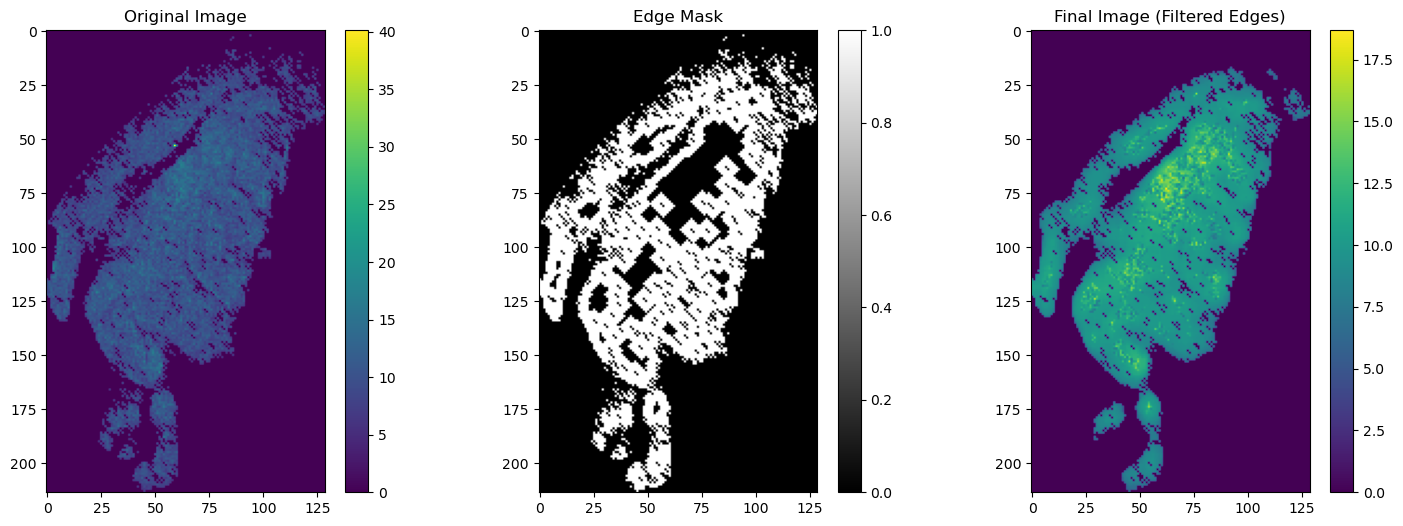

In [20]:
median_filter_size = 10
remove_residual_noise(segmented_image,median_filter_size)